# ⏳ Time Series Forecasting for OJ Sales

This project aims to build and evaluate a time series forecasting model to predict future sales for **3** different food products. By leveraging historical sales data, we apply machine learning and statistical modeling techniques to generate accurate forecasts that can support inventory planning, supply chain optimization, and data-driven business decisions.

---

### 🔍 Project Objectives:
- Load and explore Minute Maid sales time series data.
- Perform preprocessing (handling missing values, trend/seasonality decomposition).
- Build and compare forecasting models (XGBRegressor, Prophet, ElasticNet, etc.).
- Evaluate forecast accuracy using metrics like RMSE and MAPE.
- Visualize predictions and generate actionable insights.


# 1. Import Libraries

In [20]:
# Data import
from azureml.opendatasets import OjSalesSimulated

# os tools
import os
import shutil
import glob
import pandas as pd
import mlflow

# metric libraries
from sklearn.metrics import mean_absolute_error, median_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# time series models
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from statsforecast.models import AutoARIMA, SeasonalNaive, Naive

# plotting the metrcis graph lib
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline


# 2. Download Datasets from azureml 

In [5]:
# string for folder name for data
ojsales_data_path = "ojsalesdata"

# if the folder path exists then dont mind 
# but if it isn't the case then create one
if not os.path.exists(ojsales_data_path):
    os.mkdir(ojsales_data_path)

# initialize OJsales data obj
ojdata_obj = OjSalesSimulated()

# pulling the files in the oj simulated opendatasets from azureml
ojsales_datafiles = ojdata_obj.get_file_dataset()

# download the data into this specific folder, 
# also incase it already exists still write on top of that file 
ojsales_datafiles.download(ojsales_data_path, overwrite=True)


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}


['F:\\SkillUp TechMaster 2024-25\\TechMaster DP-100\\DP100-project\\ojsalesdata\\https%3A/%2Fazureopendatastorage.azurefd.net/ojsales-simulatedcontainer/oj_sales_data/Store1000_dominicks.csv',
 'F:\\SkillUp TechMaster 2024-25\\TechMaster DP-100\\DP100-project\\ojsalesdata\\https%3A/%2Fazureopendatastorage.azurefd.net/ojsales-simulatedcontainer/oj_sales_data/Store1006_tropicana.csv',
 'F:\\SkillUp TechMaster 2024-25\\TechMaster DP-100\\DP100-project\\ojsalesdata\\https%3A/%2Fazureopendatastorage.azurefd.net/ojsales-simulatedcontainer/oj_sales_data/Store1013_minute.maid.csv',
 'F:\\SkillUp TechMaster 2024-25\\TechMaster DP-100\\DP100-project\\ojsalesdata\\https%3A/%2Fazureopendatastorage.azurefd.net/ojsales-simulatedcontainer/oj_sales_data/Store1020_dominicks.csv',
 'F:\\SkillUp TechMaster 2024-25\\TechMaster DP-100\\DP100-project\\ojsalesdata\\https%3A/%2Fazureopendatastorage.azurefd.net/ojsales-simulatedcontainer/oj_sales_data/Store1026_tropicana.csv',
 'F:\\SkillUp TechMaster 2024-25\

# 3. Extract Data 

In [21]:
# real path for local pc data location
real_local_support_path = r"F:\SkillUp TechMaster 2024-25\TechMaster DP-100\DP100-project\ojsalesdata\https%3A\%2Fazureopendatastorage.azurefd.net\ojsales-simulatedcontainer\oj_sales_data"

# Create an empty list to hold individual DataFrames
all_dfs = []

# Use glob to find all CSV files in the specified directory
csv_files = glob.glob(os.path.join(real_local_support_path, "*.csv"))

# Iterate through each CSV file
for file_path in csv_files:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    all_dfs.append(df)


# 4. Getting the Data Ready

In [22]:
# Concatenate all DataFrames in the list into a single DataFrame
# This will stack them vertically, creating the desired long format
combined_df = pd.concat(all_dfs, ignore_index=True)

# Ensure 'WeekStarting' is a datetime object for time series operations
combined_df['WeekStarting'] = pd.to_datetime(combined_df['WeekStarting'])

In [23]:
# Display the first few rows and the info to verify the structure
print("Combined DataFrame Head:")
print(combined_df.head())
print("\nCombined DataFrame Info:")
combined_df.info()

Combined DataFrame Head:
  WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue
0   1990-06-14   1000  dominicks     12003       1   2.59  31087.77
1   1990-06-21   1000  dominicks     10239       1   2.39  24471.21
2   1990-06-28   1000  dominicks     17917       1   2.48  44434.16
3   1990-07-05   1000  dominicks     14218       1   2.33  33127.94
4   1990-07-12   1000  dominicks     15925       1   2.01  32009.25

Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  int64         
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue 

In [24]:
# unique Brands out there
combined_df["Brand"].unique()

array(['dominicks', 'minute.maid', 'tropicana'], dtype=object)

In [25]:
# how many rows are there for a certain store numbers
combined_df[combined_df["Store"]==138]

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
141570,1990-06-14,138,dominicks,15719,1,2.03,31909.57
141571,1990-06-21,138,dominicks,9882,1,2.58,25495.56
141572,1990-06-28,138,dominicks,18214,1,2.47,44988.58
141573,1990-07-05,138,dominicks,13987,1,2.37,33149.19
141574,1990-07-12,138,dominicks,15735,1,2.68,42169.80
...,...,...,...,...,...,...,...
141928,1992-09-03,138,tropicana,12864,1,2.53,32545.92
141929,1992-09-10,138,tropicana,17391,1,2.22,38608.02
141930,1992-09-17,138,tropicana,19427,1,2.43,47207.61
141931,1992-09-24,138,tropicana,12305,1,2.03,24979.15


In [26]:
# hoe omany rows are there for a different store number
combined_df[combined_df["Store"]==1000]

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
0,1990-06-14,1000,dominicks,12003,1,2.59,31087.77
1,1990-06-21,1000,dominicks,10239,1,2.39,24471.21
2,1990-06-28,1000,dominicks,17917,1,2.48,44434.16
3,1990-07-05,1000,dominicks,14218,1,2.33,33127.94
4,1990-07-12,1000,dominicks,15925,1,2.01,32009.25
...,...,...,...,...,...,...,...
358,1992-09-03,1000,tropicana,15013,1,2.62,39334.06
359,1992-09-10,1000,tropicana,16557,1,1.91,31623.87
360,1992-09-17,1000,tropicana,18281,1,2.33,42594.73
361,1992-09-24,1000,tropicana,15442,1,2.65,40921.30


In [27]:
# the number of stores that are available in the data
len(combined_df["Store"].unique())

3991

In [28]:
# Orderby the store numbers by the weekstarting column and also re-indexing the entire df
combined_df = combined_df.sort_values(by=["Store","WeekStarting"], ascending=True).reset_index(drop=True)

# first head
combined_df.head(5)

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue
0,1990-06-14,138,dominicks,15719,1,2.03,31909.57
1,1990-06-14,138,minute.maid,10034,1,1.95,19566.30
2,1990-06-14,138,tropicana,19455,1,2.54,49415.70
3,1990-06-21,138,dominicks,9882,1,2.58,25495.56
4,1990-06-21,138,minute.maid,18154,1,1.96,35581.84


In [29]:
# information for the df
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  int64         
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue       1448733 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 77.4+ MB


## 4.1 Time Series Plots Interval Valuation

In [30]:
# --- 1. Select a Single Time Series for Plotting ---
# Let's pick an arbitrary Store and Brand for demonstration
# You might want to choose one that has a full history without missing values
sample_store = combined_df['Store'].iloc[0] # Gets the first store ID
sample_brand = combined_df['Brand'].iloc[0] # Gets the first brand name


In [31]:
# Filter the DataFrame for this specific series
single_series_df = combined_df[(combined_df['Store'] == sample_store) &
                                 (combined_df['Brand'] == sample_brand)].copy()

# Set 'WeekStarting' as the index for time series plotting functions
single_series_df = single_series_df.set_index('WeekStarting')

# Extract the 'Quantity' (or 'Revenue') column for analysis
time_series_data = single_series_df['Quantity']

# Handle any remaining NaNs in this specific series if present (e.g., from very early lags)
# For ACF/PACF, it's best to have no NaNs.
time_series_data = time_series_data.dropna()


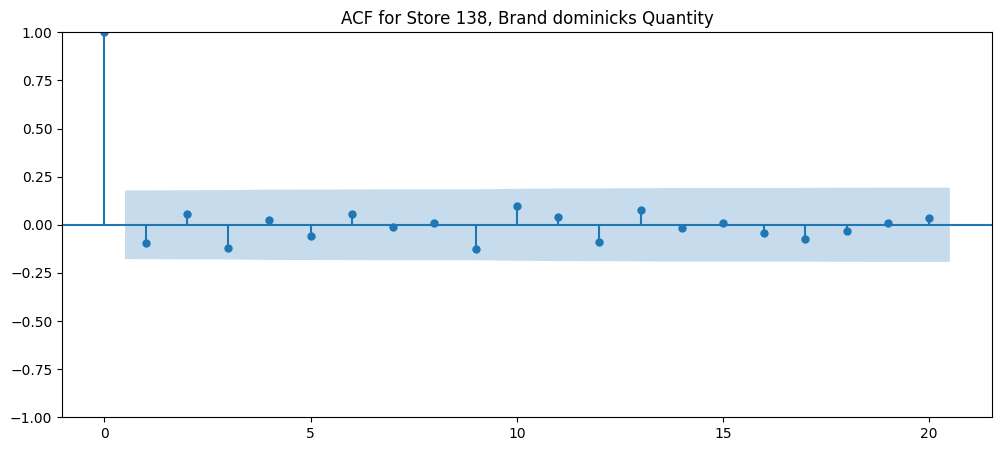

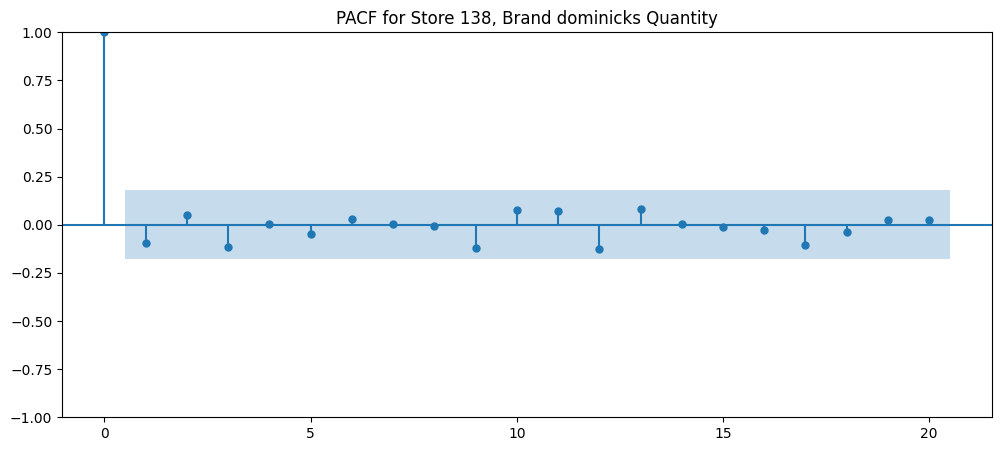

In [32]:
# plotting the 2 plots
if time_series_data.empty:
    print(f"No data available for Store {sample_store}, Brand {sample_brand} after filtering and dropping NaNs. Please try a different combination.")
else:
    # --- 2. Plot ACF (Autocorrelation Function) ---
    plt.figure(figsize=(12, 5))
    plot_acf(time_series_data, lags=20, ax=plt.gca(), title=f'ACF for Store {sample_store}, Brand {sample_brand} Quantity')
    plt.show()

    # --- 3. Plot PACF (Partial Autocorrelation Function) ---
    plt.figure(figsize=(12, 5))
    plot_pacf(time_series_data, lags=20, ax=plt.gca(), title=f'PACF for Store {sample_store}, Brand {sample_brand} Quantity')
    plt.show()


## 4.2 Feature Engineering

In [33]:

# --- Feature Engineering ---
# 1. Time-based features from 'WeekStarting'

combined_df['DayOfWeek'] = combined_df['WeekStarting'].dt.dayofweek
combined_df['Month'] = combined_df['WeekStarting'].dt.month
combined_df['WeekOfYear'] = combined_df['WeekStarting'].dt.isocalendar().week.astype(int)
combined_df['Year'] = combined_df['WeekStarting'].dt.year
combined_df['DayOfMonth'] = combined_df['WeekStarting'].dt.day
combined_df['IsMonthStart'] = combined_df['WeekStarting'].dt.is_month_start.astype(int)
combined_df['IsMonthEnd'] = combined_df['WeekStarting'].dt.is_month_end.astype(int)


In [34]:
combined_df.head(5)

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue,DayOfWeek,Month,WeekOfYear,Year,DayOfMonth,IsMonthStart,IsMonthEnd
0,1990-06-14,138,dominicks,15719,1,2.03,31909.57,3,6,24,1990,14,0,0
1,1990-06-14,138,minute.maid,10034,1,1.95,19566.30,3,6,24,1990,14,0,0
2,1990-06-14,138,tropicana,19455,1,2.54,49415.70,3,6,24,1990,14,0,0
3,1990-06-21,138,dominicks,9882,1,2.58,25495.56,3,6,25,1990,21,0,0
4,1990-06-21,138,minute.maid,18154,1,1.96,35581.84,3,6,25,1990,21,0,0


In [35]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448733 entries, 0 to 1448732
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   WeekStarting  1448733 non-null  datetime64[ns]
 1   Store         1448733 non-null  int64         
 2   Brand         1448733 non-null  object        
 3   Quantity      1448733 non-null  int64         
 4   Advert        1448733 non-null  int64         
 5   Price         1448733 non-null  float64       
 6   Revenue       1448733 non-null  float64       
 7   DayOfWeek     1448733 non-null  int64         
 8   Month         1448733 non-null  int64         
 9   WeekOfYear    1448733 non-null  int32         
 10  Year          1448733 non-null  int64         
 11  DayOfMonth    1448733 non-null  int64         
 12  IsMonthStart  1448733 non-null  int32         
 13  IsMonthEnd    1448733 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(

In [37]:
# --- 2. Create Lag Features ---
# Lag features are past values of a variable. They are crucial for time series forecasting
# because the past often influences the future.

# We will create lags for 'Quantity', 'Price', and 'Advertising'.
# The chosen lags are 1 (previous week), 2 (two weeks ago), and 4 (four weeks ago/approx. last month).
# Why 1, 2, and 4?
# - Lag 1 & 2: Capture immediate trends and short-term memory.
# - Lag 4: Captures a "monthly" cycle, assuming your data is weekly. (4 weeks = ~1 month)

# We need to calculate lags SEPARATELY for each unique Store and Brand combination.
# Otherwise, you'd get the sales of a different store/brand as a lag, which is wrong.
# `groupby(['Store', 'Brand'])` makes sure the lag calculation stays within each group.
# `.shift(n)` moves the data down by 'n' rows, so the current row gets the value from 'n' rows above it.

lag_periods = [1, 2, 4] # The number of weeks to look back
columns_to_lag = ['Quantity', 'Price', 'Advert'] # Columns for which we want lags

print("\n--- Creating Lag Features ---")
for col in columns_to_lag:
    for lag in lag_periods:
        new_col_name = f'{col}_Lag_{lag}W' # e.g., 'Quantity_Lag_1W'
        combined_df[new_col_name] = combined_df.groupby(['Store', 'Brand'])[col].shift(lag)
        print(f"Created: {new_col_name}")

print("\n--- DataFrame with new Lag Features (First few rows for one group) ---")
# Display head for a single store-brand combination to see lags clearly
print(combined_df[(combined_df['Store'] == sample_store) &
                   (combined_df['Brand'] == sample_brand)].head(7))


--- Creating Lag Features ---
Created: Quantity_Lag_1W
Created: Quantity_Lag_2W
Created: Quantity_Lag_4W
Created: Price_Lag_1W
Created: Price_Lag_2W
Created: Price_Lag_4W
Created: Advert_Lag_1W
Created: Advert_Lag_2W
Created: Advert_Lag_4W

--- DataFrame with new Lag Features (First few rows for one group) ---
   WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue  \
0    1990-06-14    138  dominicks     15719       1   2.03  31909.57   
3    1990-06-21    138  dominicks      9882       1   2.58  25495.56   
6    1990-06-28    138  dominicks     18214       1   2.47  44988.58   
9    1990-07-05    138  dominicks     13987       1   2.37  33149.19   
12   1990-07-12    138  dominicks     15735       1   2.68  42169.80   
15   1990-07-19    138  dominicks     11980       1   2.21  26475.80   
18   1990-07-26    138  dominicks     17059       1   2.21  37700.39   

    DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0           3      6          24  ...   

In [38]:
combined_df.head(5)

,WeekStarting,Store,Brand,Quantity,Advert,Price,Revenue,DayOfWeek,Month,WeekOfYear,...,IsMonthEnd,Quantity_Lag_1W,Quantity_Lag_2W,Quantity_Lag_4W,Price_Lag_1W,Price_Lag_2W,Price_Lag_4W,Advert_Lag_1W,Advert_Lag_2W,Advert_Lag_4W
0,1990-06-14,138,dominicks,15719,1,2.03,31909.57,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-06-14,138,minute.maid,10034,1,1.95,19566.30,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-06-14,138,tropicana,19455,1,2.54,49415.70,3,6,24,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-06-21,138,dominicks,9882,1,2.58,25495.56,3,6,25,...,0,15719.0,NaN,NaN,2.03,NaN,NaN,1.0,NaN,NaN
4,1990-06-21,138,minute.maid,18154,1,1.96,35581.84,3,6,25,...,0,10034.0,NaN,NaN,1.95,NaN,NaN,1.0,NaN,NaN


In [39]:
print("DataFrame after Feature Engineering (head with new columns):")
print(combined_df.head())
print("\nCheck for NaNs created by lags:")
print(combined_df.isnull().sum())

DataFrame after Feature Engineering (head with new columns):
  WeekStarting  Store        Brand  Quantity  Advert  Price   Revenue  \
0   1990-06-14    138    dominicks     15719       1   2.03  31909.57   
1   1990-06-14    138  minute.maid     10034       1   1.95  19566.30   
2   1990-06-14    138    tropicana     19455       1   2.54  49415.70   
3   1990-06-21    138    dominicks      9882       1   2.58  25495.56   
4   1990-06-21    138  minute.maid     18154       1   1.96  35581.84   

   DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0          3      6          24  ...           0              NaN   
1          3      6          24  ...           0              NaN   
2          3      6          24  ...           0              NaN   
3          3      6          25  ...           0          15719.0   
4          3      6          25  ...           0          10034.0   

   Quantity_Lag_2W  Quantity_Lag_4W  Price_Lag_1W  Price_Lag_2W  Price_Lag_4W  \
0   

In [40]:
# --- 3. Handle Missing Values (NaNs) created by Lag Features ---
# The first few rows for each Store-Brand group will have NaNs for the lag features
# because there's no data from "the past" to look back at.
# For example, for 'Quantity_Lag_4W', the first 4 rows of each series will be NaN.

# We will fill these NaNs with 0. This implies "zero activity/value" for the missing past data.

# Get all the newly created lag feature column names
lag_features_to_fill = [col for col in combined_df.columns if '_Lag_' in col]

# Fill NaNs in ONLY these specific lag features with 0
combined_df[lag_features_to_fill] = combined_df[lag_features_to_fill].fillna(0)

print("\n--- Check for NaNs after filling Lag Features with 0 ---")
# This should show 0 NaNs for all lag columns
print(combined_df[lag_features_to_fill].isnull().sum().sum())
print("All lag feature NaNs filled with 0.")

print("\n--- DataFrame after filling NaNs (First few rows for one group) ---")
print(combined_df[(combined_df['Store'] == sample_store) &
                   (combined_df['Brand'] == sample_brand)].head(7))


--- Check for NaNs after filling Lag Features with 0 ---
0
All lag feature NaNs filled with 0.

--- DataFrame after filling NaNs (First few rows for one group) ---
   WeekStarting  Store      Brand  Quantity  Advert  Price   Revenue  \
0    1990-06-14    138  dominicks     15719       1   2.03  31909.57   
3    1990-06-21    138  dominicks      9882       1   2.58  25495.56   
6    1990-06-28    138  dominicks     18214       1   2.47  44988.58   
9    1990-07-05    138  dominicks     13987       1   2.37  33149.19   
12   1990-07-12    138  dominicks     15735       1   2.68  42169.80   
15   1990-07-19    138  dominicks     11980       1   2.21  26475.80   
18   1990-07-26    138  dominicks     17059       1   2.21  37700.39   

    DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0           3      6          24  ...           0              0.0   
3           3      6          25  ...           0          15719.0   
6           3      6          26  ...           

# 5. Data Partition

In [41]:
print(combined_df.head())
print("\nSome lag features check:")
print(combined_df[[col for col in combined_df.columns if '_Lag_' in col]].head(7))


  WeekStarting  Store        Brand  Quantity  Advert  Price   Revenue  \
0   1990-06-14    138    dominicks     15719       1   2.03  31909.57   
1   1990-06-14    138  minute.maid     10034       1   1.95  19566.30   
2   1990-06-14    138    tropicana     19455       1   2.54  49415.70   
3   1990-06-21    138    dominicks      9882       1   2.58  25495.56   
4   1990-06-21    138  minute.maid     18154       1   1.96  35581.84   

   DayOfWeek  Month  WeekOfYear  ...  IsMonthEnd  Quantity_Lag_1W  \
0          3      6          24  ...           0              0.0   
1          3      6          24  ...           0              0.0   
2          3      6          24  ...           0              0.0   
3          3      6          25  ...           0          15719.0   
4          3      6          25  ...           0          10034.0   

   Quantity_Lag_2W  Quantity_Lag_4W  Price_Lag_1W  Price_Lag_2W  Price_Lag_4W  \
0              0.0              0.0          0.00           0.0  

In [42]:
# Prepare Data for Sklearn-like Models (XGBRegressor, ElasticNet) ---
# These models use ALL our engineered features (lags, time features, Store/Brand IDs)
# to predict 'Quantity'.

target_column = 'Quantity' # What we want to predict

# Define the features (X) that our model will use.
# These include all the new time-based features, original features (Price, Advert),
# and the newly created lag features.
# We exclude 'WeekStarting' itself and the 'Quantity' (target) from features.
features = [col for col in combined_df.columns if col not in ['WeekStarting', target_column]]

# For tree-based models like XGBoost, and also for ElasticNet (though less critical for ElasticNet),
# it's good practice to treat categorical columns correctly.
# We'll explicitly tell the model these are categories.
categorical_features = ['Store', 'Brand', 'DayOfWeek', 'Month', 'WeekOfYear', 'Year', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd']

print("\n--- Features (X) to be used by XGBoost and ElasticNet ---")
print(features)
print("\n--- Categorical Features for Model ---")
print(categorical_features)


--- Features (X) to be used by XGBoost and ElasticNet ---
['Store', 'Brand', 'Advert', 'Price', 'Revenue', 'DayOfWeek', 'Month', 'WeekOfYear', 'Year', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd', 'Quantity_Lag_1W', 'Quantity_Lag_2W', 'Quantity_Lag_4W', 'Price_Lag_1W', 'Price_Lag_2W', 'Price_Lag_4W', 'Advert_Lag_1W', 'Advert_Lag_2W', 'Advert_Lag_4W']

--- Categorical Features for Model ---
['Store', 'Brand', 'DayOfWeek', 'Month', 'WeekOfYear', 'Year', 'DayOfMonth', 'IsMonthStart', 'IsMonthEnd']


In [46]:
# For time series, we always train on past data and predict on future data.
# We determine a `cutoff_date` to split our data.

# Find the latest date in your dataset
max_date = combined_df['WeekStarting'].max()

# Decide how many weeks you want in your test set (e.g., the last 12 weeks for a full quarter)
test_weeks = 16
cutoff_date = max_date - pd.Timedelta(weeks=test_weeks)


In [47]:

# Split the DataFrame into training and testing sets
train_df = combined_df[combined_df['WeekStarting'] <= cutoff_date].copy()
test_df = combined_df[combined_df['WeekStarting'] > cutoff_date].copy()

# Prepare X (features) and y (target) for both train and test sets
X_train = train_df[features]
y_train = train_df[target_column]

X_test = test_df[features]
y_test = test_df[target_column]


In [48]:
# This helps them handle these features more efficiently and correctly.
for col in categorical_features:
    # Use .loc to avoid SettingWithCopyWarning
    X_train.loc[:, col] = X_train[col].astype('category')
    X_test.loc[:, col] = X_test[col].astype('category')

print(f"\n--- Data Split Details ---")
print(f"Training data covers dates up to: {cutoff_date.date()}")
print(f"Test data covers dates from: {(cutoff_date + pd.Timedelta(weeks=1)).date()} to {max_date.date()}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, col] = X_train[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, col] = X_test[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index


--- Data Split Details ---
Training data covers dates up to: 1992-06-11
Test data covers dates from: 1992-06-18 to 1992-10-01
X_train shape: (1257165, 21), y_train shape: (1257165,)
X_test shape: (191568, 21), y_test shape: (191568,)


C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, col] = X_train[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:, col] = X_test[col].astype('category')
C:\Users\preda\AppData\Local\Temp\ipykernel_3788\3565726318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [49]:
# Store actual values for later plotting
results_df = test_df[['WeekStarting', 'Store', 'Brand', 'Quantity']].copy()


# 6. Data Normalization

# 7. Model Initialization

# 8. Model Hyperparameter Tuning

# 9. Model Training

# 10. Model Metrics Final outputs